# Initial Setup

In [2]:
!pip install torchinfo torchviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple
import math
import time

from dataclasses import dataclass # decorator for classes with less boilerplate: Auto-generates __init__, __repr__, etc.
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F # Functional interface for operations (activations, pooling, etc.)
import torch.optim as optim  # Optimization algorithms (SGD, Adam, etc.)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset  # DataLoader: Handles batching, shuffling, parallel loading. Dataset: Abstract class for custom datasets

from torchinfo import summary
from torchviz import make_dot



# autocast: Automatic Mixed Precision - uses float16 where possible to speed up training while maintaining float32 for operations that need precision
# GradScaler: Scales gradients to prevent underflow when using float16.  Essential for stable mixed precision training
from torch.cuda.amp import autocast, GradScaler

from functools import partial # Creates partial functions by fixing some arguments. Useful for creating customized functions from general ones




np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.6.0+cu124


### Helper for Visualization of Attention

In [4]:
def visualize_attention(attention_weights, tokens=None, title="Attention Weights"):
  """
  Visualize attetion weight matrix

  attention_weights: 2D tensor/array where element [i,j] shows how much
                    query position i attends to key position j
  tokens: Optional list of token strings for axis labels
  title: Plot title

  Attention weights show which parts of input the model focuses on
  Darker colors = higher attention scores
  """

  plt.figure(figsize=(10,8))

  sns.heatmap(
      attention_weights,
      cmap="Blues",
      cbar=True,
      square=True,
      xticklabels=tokens if tokens else False,
      yticklabels=tokens if tokens else False
  )
  plt.title(title)
  plt.xlabel("Keys")
  plt.ylabel("Queries")
  plt.show()


# Simplified Dot-Product Attention (Vanilla)

In [5]:
def simplified_attention(X):
  """
  Simplified attention mechanism
  ai = Σ αij*xj where αij = softmax(xi·xj)
  """

  N,d = X.shape  # N = number of tokens/positions, d = embedding dimension
  print(f"Input shape: {X.shape} (N={N} tokens, d={d} dims)")

  # Compute similarity scores with dot prod
  scores = np.zeros((N,N)) # (All the tokens x All the tokens) matrix
  for i in range(N):
    for j in range(N):
      if j <= i: # Causal mask, only attending to prev tokens. Token at position i can only "see" positions 0 to i
        scores[i,j] = np.dot(X[i], X[j])
      else:
        scores[i,j] = -np.inf

  print(f"\nScores shape:\n {scores.shape}")
  print(f"Scores:\n {np.round(scores,4)}\n")

  # Apply softmax for attention weights
  attention_weights = np.zeros_like(scores) # Return an array of zeros with the same shape and type as a given array.

  for i in range(N):
    exp_scores = np.exp(scores[i] - np.max(scores[i]))    #NUMERICAL STABILITY TRICK: Subtract max before exponentiating
    print("\nexp_scores: \n", exp_scores)
    attention_weights[i] = exp_scores / np.sum(exp_scores) # Normalize to get probs
    print(f"\nattention_weights[{i}]:\n ", attention_weights[i],"\n")


  print(f"attention_weights:\n ", np.round(attention_weights,3),"\n")

  print("attention_weights.shape:\n", attention_weights.shape)
  print("\n\n")


  print("Computation of Outputs\n")
  # Weighted sum for output
  output = np.zeros_like(X) # shape (N,d)
  for i in range(N):
    for j in range(i+1): # Only sum over positions we can attend to (causal)
      print(f"Current  output[{i}]: Embedding {output[i]} +=  Attention weight({attention_weights[i,j]}) * Input of X[{j}] ({X[j]})")

      output[i] += attention_weights[i,j] * X[j] # Each output token is a weighted combination of input tokens

      print(f"Updated  output[{i}]: Embedding {output[i]} \n")

  print(f"Output:\n {output}")

  print(f"Output shape: {output.shape}")
  return output, attention_weights


#### Simple test

Input shape: (8, 4) (N=8 tokens, d=4 dims)

Scores shape:
 (8, 8)
Scores:
 [[ 3.005     -inf    -inf    -inf    -inf    -inf    -inf    -inf]
 [ 2.1077  3.1925    -inf    -inf    -inf    -inf    -inf    -inf]
 [-1.3177 -1.1064  0.9464    -inf    -inf    -inf    -inf    -inf]
 [-1.5889 -2.7642 -0.0904  7.0107    -inf    -inf    -inf    -inf]
 [-3.2856 -2.3542  1.7245  1.5141  3.9437    -inf    -inf    -inf]
 [-1.367  -1.2771 -0.1783  1.4712  0.3955  4.2336    -inf    -inf]
 [-0.459  -1.4278  0.6742  1.4302  1.1008 -1.4359  1.7746    -inf]
 [ 2.1733  0.6802 -0.4601  0.4091 -1.5529 -3.4941  1.6831  4.2388]]


exp_scores: 
 [1. 0. 0. 0. 0. 0. 0. 0.]

attention_weights[0]:
  [1. 0. 0. 0. 0. 0. 0. 0.] 


exp_scores: 
 [0.33797358 1.         0.         0.         0.         0.
 0.         0.        ]

attention_weights[1]:
  [0.25260108 0.74739892 0.         0.         0.         0.
 0.         0.        ] 


exp_scores: 
 [0.10392148 0.12837566 1.         0.         0.         0.
 0.        

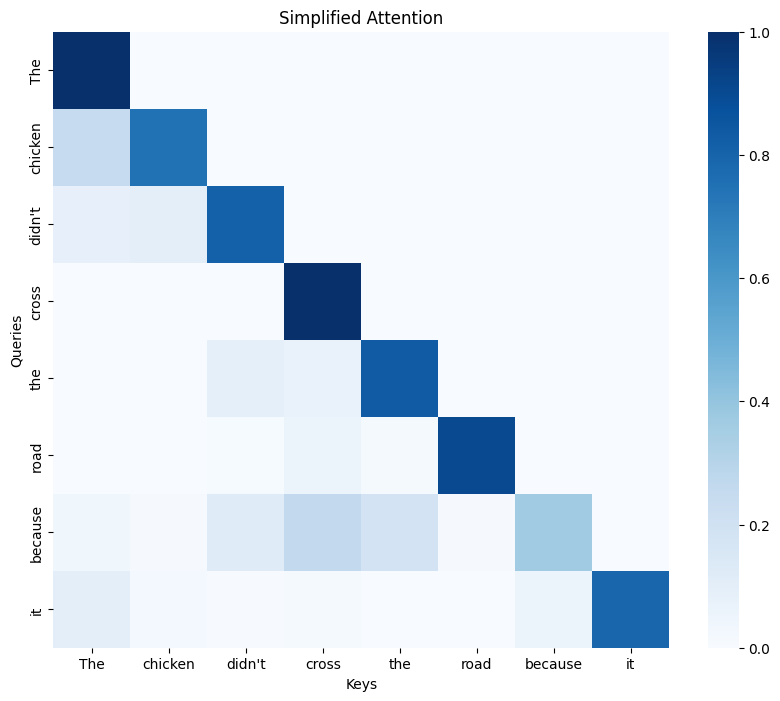

In [6]:
tokens = ["The", "chicken", "didn't", "cross", "the", "road", "because", "it"]
X = np.random.randn(len(tokens), 4)  # 8 tokens, 4 dims. In real models, dimensions are typically 512, 768, or 1024
output, weights = simplified_attention(X)

# Viz
visualize_attention(weights[:, :len(tokens)], tokens, "Simplified Attention")


# Attention with Q, K, V Matrices using NumPy

In [7]:
class AttentionNumpy:
  """
  Single attention head with Query, Key, Value matrices

  d_model: Dimension of input/output embeddings (model's hidden size)
  d_k: Dimension of queries and keys (typically d_model / num_heads)
  d_v: Dimension of values (often same as d_k)
  """

  def __init__(self, d_model, d_k, d_v):
    self.d_model = d_model
    self.d_k = d_k
    self.d_v = d_v

    # Initialize weight matrices
    self.W_Q = np.random.randn(d_model, d_k) * 0.1 # Query Projection
    self.W_K = np.random.randn(d_model, d_k) * 0.1 # Key Projection
    self.W_V = np.random.randn(d_model, d_v) * 0.1 # Value Projection

    self.W_O = np.random.randn(d_v, d_model) * 0.1  # Output projection: Projects concatenated/summed attention outputs back to model dimension

    print(f"Initialized weights: W_Q{self.W_Q.shape}, W_K{self.W_K.shape}, W_V{self.W_V.shape}, W_O{self.W_O.shape}")


  def forward(self, X):
    """
    X: [N, d_model] input sequence
    Returns: [N, d_model] attention output
    """

    N = X.shape[0] # Num of tokens/positions of the sequence

    Q = X @ self.W_Q # shpae [N, d_k]
    K = X @ self.W_K # shpae [N, d_k]
    V = X @ self.W_V # shpae [N, d_v]

    print(f"Q: {Q.shape}, K: {K.shape}, V: {V.shape}")


    # Scaled dot prod attention
    scores = (Q @ K.T) / np.sqrt(self.d_k) # [N, N]

    # Causal mask
    mask = np.triu(np.ones((N,N)) * -np.inf, k=1)
    scores = scores + mask

    # Softmax
    exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True)) # np.triu: Upper triangular matrix (k=1 means above main diagonal)
    attention_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True) #  axis=-1: Apply along last dimension (rows) ;  keepdims=True: Maintains shape for broadcasting

    print(f"\nexp_scores shape: {exp_scores.shape}\n")
    print(f"\nexp_scores:\n {exp_scores.round(3)}\n")

    print(f"\nAttention weights shape: {attention_weights.shape}\n")
    print(f"\nAttention weights:\n {attention_weights.round(3)}\n")


    # Weighted sum of values
    head_output = attention_weights @ V # [N, d_v]

    # Output projection
    output = head_output @ self.W_O # [N, d_model]

    return output, attention_weights


#### Simple test

Initialized weights: W_Q(8, 4), W_K(8, 4), W_V(8, 4), W_O(4, 8)
Q: (8, 4), K: (8, 4), V: (8, 4)

exp_scores shape: (8, 8)


exp_scores:
 [[1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.999 1.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.943 0.935 0.    0.    0.    0.    0.   ]
 [0.919 0.884 0.964 1.    0.    0.    0.    0.   ]
 [0.995 0.995 0.925 0.94  1.    0.    0.    0.   ]
 [0.969 0.917 0.91  0.98  0.947 1.    0.    0.   ]
 [0.943 0.921 0.964 1.    0.88  0.961 0.938 0.   ]
 [0.913 0.952 0.97  0.94  0.919 0.907 1.    0.939]]


Attention weights shape: (8, 8)


Attention weights:
 [[1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.5   0.5   0.    0.    0.    0.    0.    0.   ]
 [0.348 0.328 0.325 0.    0.    0.    0.    0.   ]
 [0.244 0.235 0.256 0.265 0.    0.    0.    0.   ]
 [0.205 0.205 0.191 0.194 0.206 0.    0.    0.   ]
 [0.169 0.16  0.159 0.171 0.165 0.175 0.    0.   ]
 [0.143 0.139 0.146 0.151 0.133 0.146 0.142 0.   ]
 [0.121 0.126 0.129 0.125 0.122 0.12  0.1

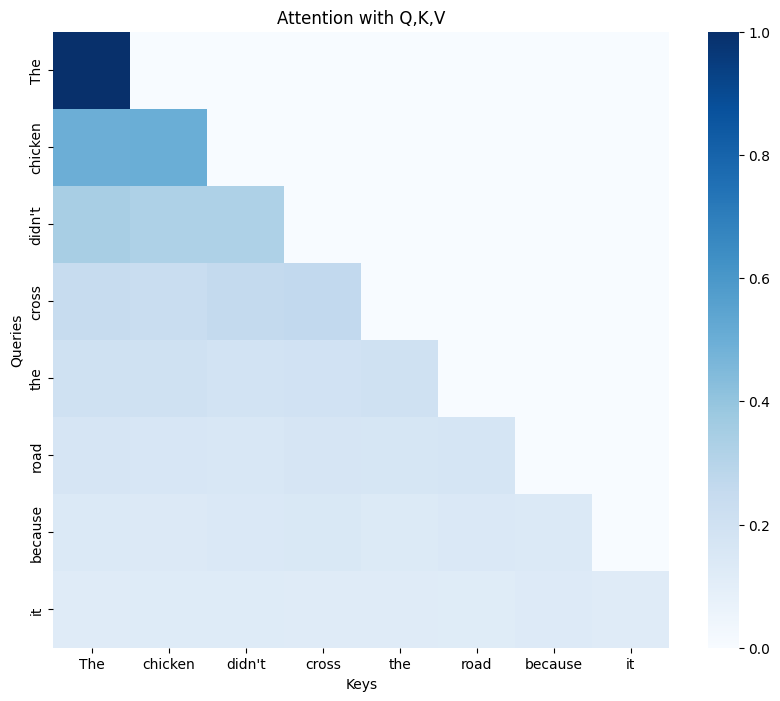

In [8]:
d_model, d_k, d_v = 8,4,4
attention = AttentionNumpy(d_model, d_k, d_v)

X = np.random.randn(len(tokens), d_model)
output, weights = attention.forward(X)

print(f"\nFinal output shape: {output.shape}")
visualize_attention(weights, tokens, "Attention with Q,K,V")

## Explanation of how nn.Linear handles batched inputs

Here's a brief explanation of how `nn.Linear` handles batched inputs:

```python
self.W_Q = nn.Linear(d_model, d_head, bias=False)
# Creates a weight matrix of shape [d_model, d_head]
# This is just a matrix, like W_Q = [[w11, w12, ...], [w21, w22, ...], ...]

Q = self.W_Q(x)  # x shape: [batch, seq_len, d_model]
                 # Q shape: [batch, seq_len, d_head]
```

**What's happening under the hood:**

`nn.Linear` is smart about dimensions. It applies matrix multiplication to the **last dimension** while preserving all previous dimensions:

```python
# What nn.Linear does internally (simplified):
# For input x with shape [batch, seq_len, d_model]
# It treats this as [*, d_model] where * = any number of preceding dimensions
# Then does: x @ W_Q.T for the last dimension

# Effectively, for each batch and each position:
# Q[batch_i][seq_j] = x[batch_i][seq_j] @ W_Q.T
# where @ is matrix multiply
```

**THE ONLY REQUIREMENT:**
- Input's **last dimension** must equal the Linear layer's **in_features**
- Everything else (batch size, sequence length, extra dimensions) can be anything

**Examples:**
```python
layer = nn.Linear(64, 32)  # Expects last dim = 64, outputs last dim = 32

# ✅ These all work:
layer(torch.randn(10, 64))        # [10, 64] → [10, 32]
layer(torch.randn(5, 20, 64))     # [5, 20, 64] → [5, 20, 32]
layer(torch.randn(2, 8, 12, 64))  # [2, 8, 12, 64] → [2, 8, 12, 32]

# ❌ These fail:
layer(torch.randn(10, 32))        # Error! Last dim 32 ≠ 64
layer(torch.randn(5, 20, 128))    # Error! Last dim 128 ≠ 64
```



**Visual example:**
```
If x = [2, 8, 64]  (2 batches, 8 positions, 64-dim embeddings)
   W_Q = [64, 16]   (transforms 64-dim → 16-dim)
   
nn.Linear applies the SAME weight matrix to:
- Batch 0, Position 0: [64] → [16]
- Batch 0, Position 1: [64] → [16]
- ...
- Batch 1, Position 7: [64] → [16]

Result Q = [2, 8, 16]  (same batch & seq_len, new dimension)
```

**The key insight:** `nn.Linear` automatically broadcasts its operation across all dimensions except the last one, so you don't need to write loops over batches or sequences. One weight matrix, applied everywhere!




**In summary:** Only the **last dimension** needs to match the layer's `in_features`. All other dimensions pass through unchanged.


# Single Attention Head using PyTorch

In [9]:
class AttentionHead(nn.Module):
  """
  PyTorch implementation of a single attention head

  d_model is the dimension of input/output embeddings (model's hidden size)
  d_head  is the compressed/projected dimension for computational efficiency and multi-head splitting, usually the embedding // num of attention heads

  """

  def __init__(self, d_model, d_head):
    super(AttentionHead,self).__init__()  #Initialize parent nn.Module class, this registers parameters and enables .to(device), .train(), etc.

    self.d_head  = d_head # Dimension of this attention head, although total model may have multiple heads (multi-head attention)

    # Linear projections for Q, K, V
    self.W_Q = nn.Linear(d_model, d_head, bias = False)
    self.W_K = nn.Linear(d_model, d_head, bias = False)
    self.W_V = nn.Linear(d_model, d_head, bias = False)
    self.W_O = nn.Linear(d_head, d_model, bias = False) # shape (hidden, output)

    self.scale = 1.0 / math.sqrt(d_head) # Pre-compute scaling factor for efficiency to prevent softmax saturation

  def forward(self, x, mask=None):
    """
    x: [batch, seq_len, d_model] ## PyTorch convention: batch dimension first for efficiency. This allows processing multiple sequences in parallel on GPU
    Returns: [batch, seq_len, d_model], attention_weights
    """

    batch_size, seq_len, d_model = x.shape


    # comput Q, K, V
    Q = self.W_Q(x)  # [batch, seq_len, d_head]  PyTorch's nn.Linear automatically handles batch dimension. It applies the same transformation to each batch element
    K = self.W_K(x)  # nn.Linear is smart about dimensions. It applies matrix multiplication to the last dimension while preserving all previous dimensions
    V = self.W_V(x)

    # Scaled dot prod attention
    scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale # [batch, seq_len, seq_len].   K.transpose(-2, -1): Swaps last two dimensions (seq_len, d_head) → (d_head, seq_len). Negative indexing: -1 = last dim, -2 = second-to-last

    # Mask if provided
    if mask is not None:
      scores = scores.masked_fill(mask == 0, -1e9)

    attn_weights = F.softmax(scores, dim = -1)  # dim=-1: Apply softmax along last dimension (over keys for each query)

    # Apply attention to values
    context = torch.matmul(attn_weights, V)  # [batch, seq_len, d_head]

    # Output
    output = self.W_O(context) # [batch, seq_len, d_model]  Project head dim back to model dim. Enables residual connections in full Transformer

    return(output, attn_weights)




### Test Multi-Head Attention

Input shape: torch.Size([2, 8, 64])
Mask shape: torch.Size([1, 8, 8])
Output shape: torch.Size([2, 8, 64])
Attention weights shape: torch.Size([2, 8, 8])


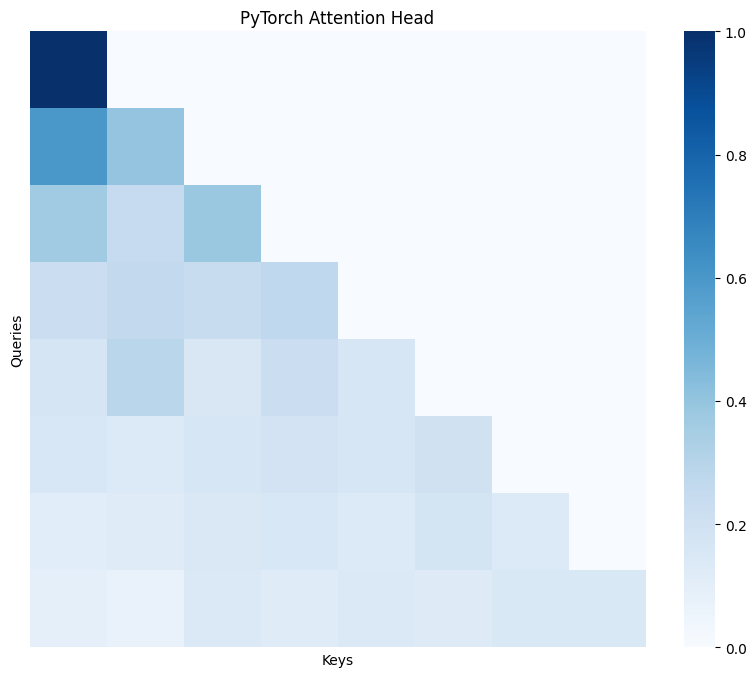

Layer (type:depth-idx)                   Output Shape              Param #
AttentionHead                            [2, 8, 64]                --
├─Linear: 1-1                            [2, 8, 16]                1,024
├─Linear: 1-2                            [2, 8, 16]                1,024
├─Linear: 1-3                            [2, 8, 16]                1,024
├─Linear: 1-4                            [2, 8, 64]                1,024
Total params: 4,096
Trainable params: 4,096
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.04

In [10]:
# Test PyTorch attention head
d_model, d_head = 64, 16
attention_head = AttentionHead(d_model, d_head)

# Create sample input
batch_size, seq_len = 2, 8
x = torch.randn(batch_size, seq_len, d_model)

# Create causal mask
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
print(f"Input shape: {x.shape}")
print(f"Mask shape: {mask.shape}")

output, attn_weights = attention_head(x, mask)
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

# Visualize attention for first batch
visualize_attention(attn_weights[0].detach().numpy(), title="PyTorch Attention Head")

# Model summary
summary(attention_head, input_data=[x, mask], verbose=0)

#Multi-Head Attention with NumPy


In [11]:
class MultiHeadAttentionNumPy:
  """Multi-Head attention mechanism"""

  def __init__(self, d_model, n_heads, d_k, d_v):
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_k
    self.d_v = d_k

    self.W_Q = [np.random.randn(d_model, d_k) * 0.1 for _ in range(n_heads)  ]
    self.W_K = [np.random.randn(d_model, d_k) * 0.1 for _ in range(n_heads)  ]
    self.W_V = [np.random.randn(d_model, d_v) * 0.1 for _ in range(n_heads)  ]
    self.W_O = np.random.randn(n_heads * d_v, d_model) * 0.1

    print(f"Multi-head attention: {n_heads} heads, d_k={d_k}, d_v={d_v}")

  def forward(self, X):
    """
    X: [N, d_model]
    Returns: [N, d_model], list of attention weights per head
    """


    N = X.shape[0]
    head_outputs = []
    attention_weights_all = []

    # Processing each head
    for h in range(self.n_heads):
      # Compute Q, K, V per head
      Q_h = X @ self.W_Q[h]
      K_h = X @ self.W_K[h]
      V_h = X @ self.W_V[h]

      # scaled dot prod attntion
      scores = (Q_h @ K_h.T) / (np.sqrt(self.d_k))

      # causal mask
      mask = np.triu(np.ones((N,N)) * -np.inf,k=1 )
      scores = scores + mask

      # softmax with optimization and normalization
      exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))  # Numerical stability trick: subtract max before exp
      attn_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True) # Normalize to get probabilities [N, N]
      attention_weights_all.append(attn_weights)

      # Weighted sum
      head_out = attn_weights @ V_h  # [N, N] × [N, d_v] = [N, d_v] - Weighted combination of values
      head_outputs.append(head_out)

    # Concat heads
    concat_heads = np.concatenate(head_outputs, axis=1) # [N, d_v] × n_heads → [N, n_heads * d_v]
    print(f"Concatenated heads shape: {concat_heads.shape}")

    # Output projection
    output = concat_heads @ self.W_O  # [N, n_heads*d_v] × [n_heads*d_v, d_model] = [N, d_model] - Final output

    return(output, attention_weights_all)

### Test multi-head attention with Numpy


Multi-head attention: 4 heads, d_k=16, d_v=16
Concatenated heads shape: (8, 64)
Output shape: (8, 64)
Number of attention matrices: 4


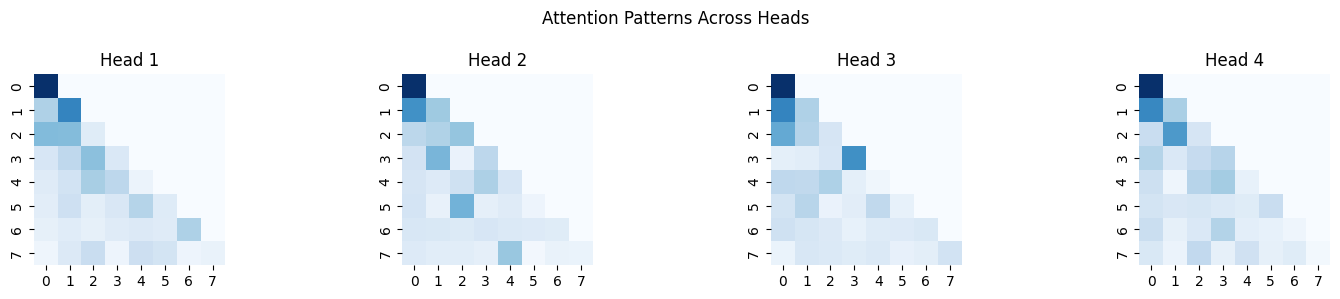

In [12]:
d_model, n_heads = 64, 4  # 64-dim embeddings, 4 parallel attention heads
d_k = d_v = d_model // n_heads  # 16 dims per head (64/4)
mha = MultiHeadAttentionNumPy(d_model, n_heads, d_k, d_v)
X = np.random.randn(8, d_model)  # Input: 8 tokens, each 64-dimensional
output, attn_weights_list = mha.forward(X)
print(f"Output shape: {output.shape}")  # Should be [8, 64]
print(f"Number of attention matrices: {len(attn_weights_list)}")  # Should be 4 (one per head)

# Visualize attention from different heads
fig, axes = plt.subplots(1, n_heads, figsize=(15, 3))
for i, (ax, attn) in enumerate(zip(axes, attn_weights_list)):
    sns.heatmap(attn, ax=ax, cmap='Blues', cbar=False, square=True)  # Each head learns different attention patterns
    ax.set_title(f"Head {i+1}")
plt.suptitle("Attention Patterns Across Heads")  # Different heads capture different relationships
plt.tight_layout()
plt.show()

#Multi-Head Attention with PyTorch

In [13]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads, dropout=0.1):
    super().__init__()

    assert d_model % n_heads == 0 # Ensure d_model is divisible by n_heads for even split

    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_model // n_heads

    # Single projection for all heads (more efficient)
    self.W_Q = nn.Linear(d_model, d_model, bias=False)
    self.W_K = nn.Linear(d_model, d_model, bias=False)
    self.W_V = nn.Linear(d_model, d_model, bias=False)
    self.W_O = nn.Linear(d_model, d_model, bias=False)

    self.dropout = nn.Dropout(dropout) # Regularization
    self.scale = 1.0 / math.sqrt(self.d_k)

  def forward(self, x, mask=None):
    """
    x: [batch, seq_len, d_model]
    Returns:
      x: [batch, seq_len, d_model] - transformed output
      attn_weights: [batch, n_heads, seq_len, seq_len] - attention weights
    """

    batch_size, seq_len, d_model = x.shape

    # Linear projections in batch from d_model => n_heads * d_k
    Q = self.W_Q(x).view(batch_size, seq_len, self.n_heads, self.d_k)  # [B, L, d] → [B, L, h, d_k] - Reshape to separate heads. view() is O(1) - just changes stride info. Each head gets d_k dimensions
    K = self.W_K(x).view(batch_size, seq_len, self.n_heads, self.d_k)
    V = self.W_V(x).view(batch_size, seq_len, self.n_heads, self.d_k)


    print(f"\nQ shape before transpose: {Q.shape}")


    # Transpose for attention: [batch, n_heads, seq_len, d_k].  [B, L, h, d_k] -> [B, h, L, d_k]
    Q = Q.transpose(1,2) # moves position 1 to position 2
    K = K.transpose(1,2)
    V = V.transpose(1,2)

    print(f"Q shape after transpose: {Q.shape}\n")


    # Scaled dot-product attention
    scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # [B, h, L, d_k] × [B, h, d_k, L] = [B, h, L, L]
    print(f"Attention scores shape: {scores.shape}\n")  # Each position attends to all positions


    # Apply mask
    if mask is not None:
       mask = mask.unsqueeze(0).unsqueeze(1) # [L,L] -> [1,L,L] broadcasting for heads dimension
       scores = scores.masked_fill(mask == 0, -1e9)

    # Softmax
    attn_weights = F.softmax(scores,dim=-1)
    attn_weights = self.dropout(attn_weights) # Dropout

    # Apply attention to values
    context = torch.matmul(attn_weights, V)  # [B, h, L, L] × [B, h, L, d_k] = [B, h, L, d_k] - Weighted sum of values

    # Cncat heads
    context = context.transpose(1, 2).contiguous().view(  # transpose back: [B, L, h, d_k]
        batch_size, seq_len, d_model  # view: [B, L, h*d_k] = [B, L, d_model] - Merge all heads
    )  # contiguous() ensures memory layout is sequential after transpose (required for view)
    print(f"Context after concatenation: {context.shape}\n")

    # final linear projection
    output = self.W_O(context)  # [B, L, d_model] → [B, L, d_model] - Mix information from all heads

    return(output, attn_weights)


### Test PyTorch Multi-head attention


In [14]:
mha_torch = MultiHeadAttention(d_model=128, n_heads=8)  # 8 heads × 16 dims = 128 total
x = torch.randn(2, 10, 128)  # [batch=2, seq=10, d_model=128] - 2 sequences, 10 tokens each
mask = torch.tril(torch.ones(10, 10))  # Lower triangular causal mask (can't attend to future)
output, attn_weights = mha_torch(x, mask)
print(f"\nFinal output shape: {output.shape}")  # Should be [2, 10, 128]
print(f"Attention weights shape: {attn_weights.shape}")  # [2, 8, 10, 10] - attention map per head per batch

# Create computation graph
y = output.mean()  # Scalar output needed for autograd graph
graph = make_dot(y, params=dict(mha_torch.named_parameters()))  # Visualize backward pass connections
graph.render("Multi_head_attention", format="png", cleanup=True)
print("Computation graph saved as 'Multi_head_attention.png'")


Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])


Final output shape: torch.Size([2, 10, 128])
Attention weights shape: torch.Size([2, 8, 10, 10])
Computation graph saved as 'Multi_head_attention.png'


#Feedforward Network

In [15]:
class FeedForward(nn.Module):
  """
  FFN(x) = ReLU(xW1 + b1)W2 + b2
  Usually d_ff = 4 * d_model
  """

  def __init__(self, d_model, d_ff=None, dropout=0.1, activation='relu'):
    super().__init__()

    d_ff = 4*d_model # Default: expand by 4x (e.g., 512 → 2048)

    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)

    self.dropout = nn.Dropout(dropout)

    self.activation = nn.ReLU() if activation =='relu' else nn.GELU() # GELU: smoother, differentiable everywhere
    self.activation_name = activation

    print(f"FFN: {d_model} → {d_ff} → {d_model} with {activation}")


  def forward(self,x):
    """
    x: [batch, seq_len, d_model]
    Returns: [batch, seq_len, d_model]
    """

    # First layer: linear + activation + regularization
    x = self.linear1(x) # [B, L, d_model] → [B, L, d_ff] - Project to higher dimension
    x = self.activation(x)
    x = self.dropout(x)

    # Second layer
    x = self.linear2(x) # [B, L, d_ff] → [B, L, d_model] - Project back to original dimension

    print(f"After linear2: {x.shape}")

    return(x)


### Simple test comparing ReLU vs GELU

FFN: 128 → 512 → 128 with relu
FFN: 128 → 512 → 128 with gelu
After linear2: torch.Size([2, 10, 128])
After linear2: torch.Size([2, 10, 128])


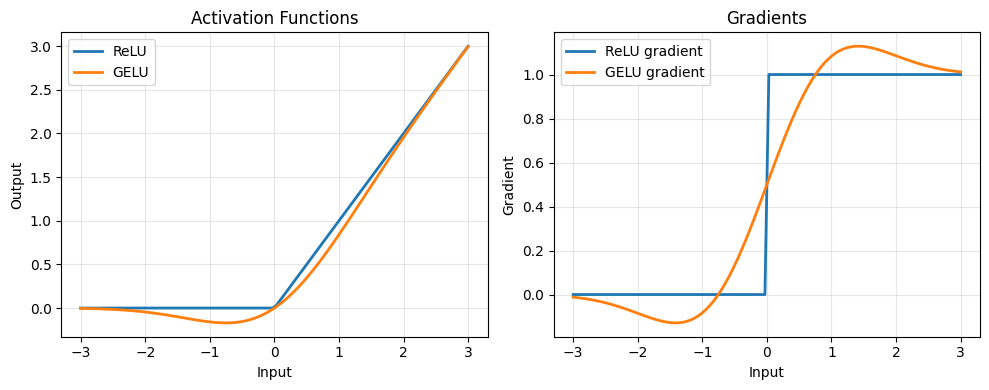

In [16]:
d_model = 128

ffn_relu = FeedForward(d_model, activation='relu')
ffn_gelu = FeedForward(d_model, activation='gelu')

x = torch.randn(2,10, d_model)   # [batch=2, seq=10, features=128]

out_relu = ffn_relu(x)
out_gelu = ffn_gelu(x)

# Visualization
x_test = torch.linspace(-3,3, 100)
relu_out = F.relu(x_test)
gelu_out = F.gelu(x_test)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(x_test, relu_out, label='ReLU', linewidth=2)
plt.plot(x_test, gelu_out, label='GELU', linewidth=2)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Activation Functions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2) # Derivatives
relu_grad = (x_test > 0).float()  # ReLU gradient: 0 if x<0, 1 if x>0 (undefined at 0)
x_test.requires_grad = True  # Enable gradient computation for GELU
gelu_out = F.gelu(x_test)
gelu_grad = torch.autograd.grad(gelu_out.sum(), x_test, create_graph=True)[0]  # Compute GELU gradient via autograd

plt.plot(x_test.detach(), relu_grad, label='ReLU gradient', linewidth=2)  # Step function
plt.plot(x_test.detach(), gelu_grad.detach(), label='GELU gradient', linewidth=2)  # Smooth S-curve
plt.xlabel('Input')
plt.ylabel('Gradient')
plt.title('Gradients')  # GELU has non-zero gradients for negative inputs (helps with dead neurons)
plt.legend()
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

#Layer Normalization with Numpy

In [17]:
class LayerNormNumPy:
  def __init__(self, d_model, eps=1e-5):
    self.d_model = d_model # Channels
    self.eps = eps # Small constant for numerical stability

    # Learnable params
    self.gamma = np.ones(d_model)
    self.beta  = np.zeros(d_model)

  def forward(self, x):
    """ Normalize over last dimetnsion"""

    # Compute mean and std
    mean = np.mean(x, axis=-1, keepdims=True) # axis=-1 apply along last dim (rows), keepdims mantain dimensionality for broadcasting
    var = np.var(x, axis=-1, keepdims=True)
    std = np.sqrt(var + self.eps) # epsilon brings num stability

    print(f"Mean shape: {mean.shape}, first 3 values: {mean.flat[:3].round(3)}\n")
    print(f"Std shape: {std.shape}, first 3 values: {std.flat[:3].round(3)}\n")


    # Normalize
    x_norm = (x-mean)/std

    # Scale and shift
    output = self.gamma * x_norm + self.beta

    print("output = self.gamma * x_norm + self.beta \n")
    print(f"output {output} =\n gamma {self.gamma} * \n x_norm{x_norm.ravel()} \n+ beta {self.beta} ")


    return(output)

In [18]:
d_model = 8
x = np.random.randn(2, 4, d_model) * 5 + 2  # Non-normalized input

# Numpy implementation
ln_numpy = LayerNormNumPy(d_model)
out_numpy = ln_numpy.forward(x)

# Same but with pyTorch
ln_torch = nn.LayerNorm(d_model)
x_torch = torch.tensor(x, dtype=torch.float32)
out_torch = ln_torch(x_torch)

print(f"\nInput stats - Mean: {x.mean():.3f}, Std: {x.std():.3f}")
print(f"Numpy output stats - Mean: {out_numpy.mean():.3f}, Std: {out_numpy.std():.16f}")
print(f"PyTorch output stats - Mean: {out_torch.mean():.3f}, Std: {out_torch.std():.16f}")

print(f"{'PyTorch' if (abs(1-out_torch.std().item()) < abs(1-out_numpy.std())) else 'NumPy'} std closest to 1.0")

Mean shape: (2, 4, 1), first 3 values: [0.889 1.195 6.311]

Std shape: (2, 4, 1), first 3 values: [4.039 5.595 4.764]

output = self.gamma * x_norm + self.beta 

output [[[ 0.05608816 -0.43263643  0.12793853  0.89538233 -2.41932988
    0.76287743  0.65769833  0.35198154]
  [ 0.01050664 -2.1494205  -0.24915214  1.74319159  0.15547978
   -0.1306787   0.15905901  0.46101432]
  [-0.21345203 -1.14518367 -0.45895448  0.8548644   0.15121159
    1.55143179 -1.59429784  0.85438023]
  [-1.23940163  0.16690202  0.63259379 -0.89540083 -0.15953033
    0.85134195 -1.14058434  1.78407938]]

 [[-1.51781366  2.0076912   1.01252731 -0.14456499 -0.47644982
   -0.58712671 -0.19342364 -0.10083967]
  [ 1.22779166  1.9014589   0.23078953 -0.7559787  -0.47279035
   -0.1303654  -0.93019016 -1.07071549]
  [ 1.63434473  0.15092271 -0.78793422  0.57580894 -1.07330209
   -1.00524121 -0.76305993  1.26846106]
  [ 0.11066001 -1.80997058  1.39435166  0.06371421 -1.29024582
    0.05467441  0.7897202   0.6870959 ]]] =
 

#Complete Transformer Block

In [19]:
class TransformerBlock(nn.Module):
  """
  Pre-norm Transformer block with Residual Connections
  x -> Norm Layer -> Residual Layer -> Norm Layer -> FeedForward -> Residual Connection
  """

  def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
    super().__init__()

    # Multi-head attention
    self.attention = MultiHeadAttention(d_model, n_heads, dropout)
    self.norm1 = nn.LayerNorm(d_model)

    # Feedforward
    self.ffn = FeedForward(d_model, d_ff, dropout)
    self.norm2 = nn.LayerNorm(d_model)

    self.dropout = nn.Dropout(dropout)


  def forward(self, x, mask=None):
    """
    x: [batch, seq_len, d_model]
    Returns: [batch, seq_len, d_model], attn_weights
    """

    # Self-attention with Residual Connection
    residual = x
    x = self.norm1(x)  # Pre-norm architecture
    attn_out, attn_weights = self.attention(x, mask)
    x = residual + self.dropout(attn_out) # Residual Connection


    # FFN with Residual Connection
    residual = x
    x = self.norm2(x) # Pre-norm arch
    ffn_out = self.ffn(x)
    x = residual + self.dropout(ffn_out)# Residual Connection


    return( x, attn_weights)


# Test transformer block


FFN: 128 → 512 → 128 with relu

Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear2: torch.Size([2, 10, 128])
Block input shape: torch.Size([2, 10, 128])
Block output shape: torch.Size([2, 10, 128])
Attention weights shape: torch.Size([2, 8, 10, 10])


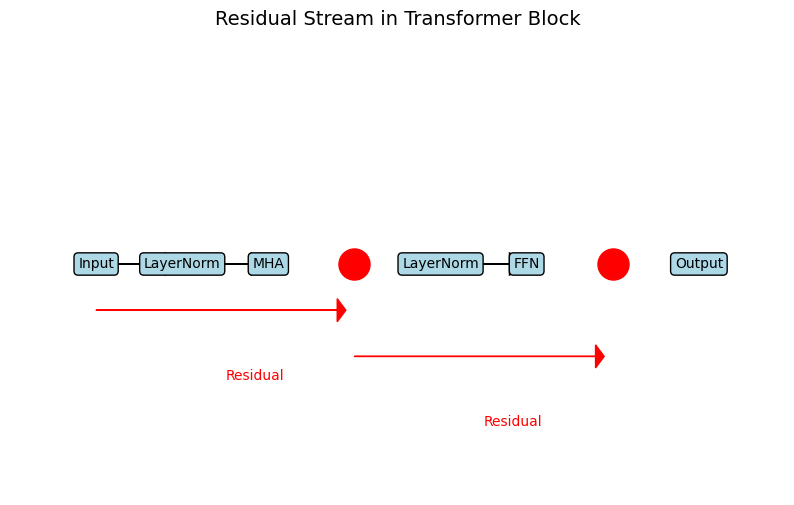


Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear2: torch.Size([2, 10, 128])


Layer (type:depth-idx)                   Output Shape              Param #
TransformerBlock                         [2, 10, 128]              --
├─LayerNorm: 1-1                         [2, 10, 128]              256
├─MultiHeadAttention: 1-2                [2, 10, 128]              --
│    └─Linear: 2-1                       [2, 10, 128]              16,384
│    └─Linear: 2-2                       [2, 10, 128]              16,384
│    └─Linear: 2-3                       [2, 10, 128]              16,384
│    └─Dropout: 2-4                      [2, 8, 10, 10]            --
│    └─Linear: 2-5                       [2, 10, 128]              16,384
├─Dropout: 1-3                           [2, 10, 128]              --
├─LayerNorm: 1-4                         [2, 10, 128]              256
├─FeedForward: 1-5                       [2, 10, 128]              --
│    └─Linear: 2-6                       [2, 10, 512]              66,048
│    └─ReLU: 2-7                         [2, 10, 512]          

In [20]:
block = TransformerBlock(d_model=128, n_heads=8)
x = torch.randn(2, 10, 128)
mask = torch.tril(torch.ones(10, 10))

output, attn_weights = block(x, mask)
print(f"Block input shape: {x.shape}")
print(f"Block output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

# Visualize residual stream concept
def visualize_residual_stream():
    """Show how information flows through residual connections"""
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw components
    components = ['Input', 'LayerNorm', 'MHA', '+', 'LayerNorm', 'FFN', '+', 'Output']
    positions = [(1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3)]

    # Residual connections
    ax.arrow(1, 2.8, 2.8, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')
    ax.text(2.5, 2.5, 'Residual', color='red')
    ax.arrow(4, 2.6, 2.8, 0, head_width=0.1, head_length=0.1, fc='red', ec='red')
    ax.text(5.5, 2.3, 'Residual', color='red')

    # Main flow
    for i, (comp, pos) in enumerate(zip(components, positions)):
        if comp == '+':
            ax.scatter(*pos, s=500, c='red', marker='o')
        else:
            ax.text(*pos, comp, ha='center', va='center',
                   bbox=dict(boxstyle='round', facecolor='lightblue'))

        if i < len(positions) - 1 and components[i] != '+' and components[i+1] != '+':
            ax.arrow(pos[0], pos[1], 0.8, 0, head_width=0.1, head_length=0.1)

    ax.set_xlim(0, 9)
    ax.set_ylim(2, 4)
    ax.axis('off')
    ax.set_title('Residual Stream in Transformer Block', fontsize=14)
    plt.show()

visualize_residual_stream()

# Model summary
summary(block, input_data=[x, mask], verbose=0)

# Stacking Transformer Blocks

In [21]:
class TransformerStack(nn.Module):
  """
  Stack of Transformer Blocks
  """

  def __init__(self, n_layers, d_model, n_heads, d_ff=None, dropout=0.1):
    super(TransformerStack, self).__init__()

    # ModuleList ensures proper parameter registration
    self.layers = nn.ModuleList([
      TransformerBlock(d_model, n_heads, d_ff, dropout)
      for _ in range(n_layers) #  Create n_layers identical blocks (but with different weights)
                                 ])

    self.n_layers = n_layers

  def forward(self, x, mask=None, return_all_hidden=False):
    """
    x: [batch, seq_len, d_model]
    Returns: [batch, seq_len, d_model] or all hidden states
    """
    hidden_states = []      # Store output from each layer for analysis
    attention_weights = []  # Store attention patterns from each layer

    for i, layer in enumerate(self.layers):
      x, attn = layer(x, mask)  # Each layer transforms x in-place (residual architecture)
      hidden_states.append(x)
      attention_weights.append(attn)
      print(f"After layer {i+1}: mean={x.mean():.3f}, std={x.std():.3f}")  # Monitor for vanishing/exploding

    if return_all_hidden:
      return x,hidden_states, attention_weights # Return intermediate representations

    return x, attention_weights


### Test stacked blocks


In [22]:
n_layers = 6  # Typical: GPT-1: 12 layers, GPT-2: 12/24/36/48 (small/medium/large/XL), BERT: 12 (base) / 24 (large), GPT-3: 12 to 96 depending on size

transformer = TransformerStack(n_layers, d_model=128, n_heads=8)
x = torch.randn(2, 10, 128)  # [batch=2, seq=10, features=128]
mask = torch.tril(torch.ones(10, 10))  # Causal mask


output, all_hidden, all_attn = transformer(x, mask, return_all_hidden=True)
print(f"\nNumber of layers: {len(all_hidden)}\n")
print(f"\nFinal output shape: {output.shape}\n")

# Add torchinfo summary
print("\n" + "="*50)
print("Transformer Stack Summary:")
summary(transformer, input_data=[x, mask], verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'])

# Add torchviz computation graph
output_for_graph, _ = transformer(x, mask)
y = output_for_graph.mean()
graph = make_dot(y, params=dict(transformer.named_parameters()))
graph.render("transformer_stack", format="png", cleanup=True)
print("Computation graph saved as 'Transformer_stack.png'")



FFN: 128 → 512 → 128 with relu
FFN: 128 → 512 → 128 with relu
FFN: 128 → 512 → 128 with relu
FFN: 128 → 512 → 128 with relu
FFN: 128 → 512 → 128 with relu
FFN: 128 → 512 → 128 with relu

Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear2: torch.Size([2, 10, 128])
After layer 1: mean=-0.014, std=1.055

Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear2: torch.Size([2, 10, 128])
After layer 2: mean=-0.026, std=1.112

Q shape before transpose: torch.Size([2, 10, 8, 16])
Q shape after transpose: torch.Size([2, 8, 10, 16])

Attention scores shape: torch.Size([2, 8, 10, 10])

Context after concatenation: torch.Size([2, 10, 128])

After linear2: t

## Analyze how representations evolve


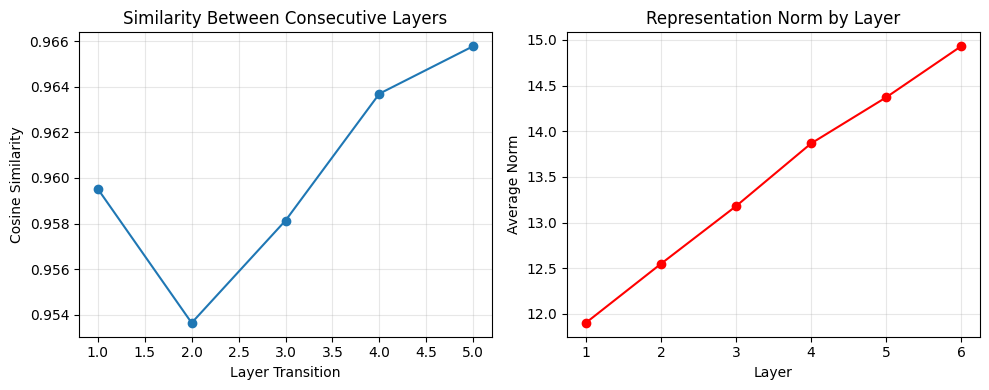


Similarity Between Consecutive Layers:
Similarity oscillates between 0.954-0.962 (extremely high!) showing the residual stream dominates. The dips at layers 2 & 5 indicate where meaningful transformations occur.
High similarity (peaks): Layer made small changes, residual dominates (refinement)
Low similarity (valleys): Layer made large changes, significant transformation occurred

Representation Norm by Layer:
Increasing Norm: Each layer adds information to the residual stream. The linear growth (~0.6 per layer) shows healthy accumulation without explosion - LayerNorm is working.

The transformer is working perfectly - it preserves 95.4%+ of information while making surgical 4-6% updates at specific layers. The wave pattern suggests alternating "compute" vs "refine" layers, which is typical transformer behavior with random initialization.


In [23]:
def analyze_layer_evolution(hidden_states):
    """Track how representations change through layers"""
    n_layers = len(hidden_states)

    # Compute similarity between consecutive layers
    similarities = []
    for i in range(n_layers - 1):
        h1 = hidden_states[i].flatten()  # Flatten to 1D for comparison
        h2 = hidden_states[i + 1].flatten()
        cos_sim = F.cosine_similarity(h1, h2, dim=0)  # How similar are consecutive layers?
        similarities.append(cos_sim.item())

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_layers), similarities, marker='o')
    plt.xlabel('Layer Transition')
    plt.ylabel('Cosine Similarity')
    plt.title('Similarity Between Consecutive Layers')  # High similarity = residual dominates; Low = layer transforms significantly
    plt.grid(True, alpha=0.3)

    # Compute norms
    plt.subplot(1, 2, 2)
    norms = [h.norm(dim=-1).mean().item() for h in hidden_states]  # L2 norm per token, averaged
    plt.plot(range(1, n_layers + 1), norms, marker='o', color='red')
    plt.xlabel('Layer')
    plt.ylabel('Average Norm')
    plt.title('Representation Norm by Layer')  # Should stay stable (not explode/vanish) due to LayerNorm
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

analyze_layer_evolution(all_hidden)


print("\nSimilarity Between Consecutive Layers:")

print("Similarity oscillates between 0.954-0.962 (extremely high!) showing the residual stream dominates. The dips at layers 2 & 5 indicate where meaningful transformations occur.")

print("High similarity (peaks): Layer made small changes, residual dominates (refinement)")
print("Low similarity (valleys): Layer made large changes, significant transformation occurred")

print("\nRepresentation Norm by Layer:")
print("Increasing Norm: Each layer adds information to the residual stream. The linear growth (~0.6 per layer) shows healthy accumulation without explosion - LayerNorm is working.")

print('\nThe transformer is working perfectly - it preserves 95.4%+ of information while making surgical 4-6% updates at specific layers. The wave pattern suggests alternating "compute" vs "refine" layers, which is typical transformer behavior with random initialization.')

## Memory usage analysis


In [24]:
def estimate_memory_usage(model):
    """Estimate memory usage of model"""
    total_params = sum(p.numel() for p in model.parameters())  # Count all parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Assuming float32
    memory_mb = (total_params * 4) / (1024 * 1024)  # 4 bytes per float32 parameter

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")  # Should equal total (all trainable)
    print(f"Estimated memory: {memory_mb:.2f} MB")  # Just parameters, not activations/gradients

    return total_params

estimate_memory_usage(transformer)  # Each layer adds ~400K params (4 matrices in MHA + 2 in FFN + 2 LayerNorms)

Total parameters: 1,186,560
Trainable parameters: 1,186,560
Estimated memory: 4.53 MB


1186560

# Parallelization: Batch Matrix Multiplication for Attention
Attention parallelization is only during forward pass (not training/backprop).

In [25]:
def parallel_attention_computation(Q,K,V,mask=None):
  """
  Efficient parallel attention computation
  Q,K,V: [batch, n_heads, seq_len, d_k]
  """

  batch_size, n_heads, seq_len, d_k = Q.shape

  # Parallel QK^T computation for all heads and batches
  # [batch, n_heads, seq_len, d_k] @ [batch, n_heads, d_k, seq_len]
  scores = torch.matmul(Q, K.transpose(-2,-1))/math.sqrt(d_k) # Normalization
  print(f"Parallel scores computation: {Q.shape} @ {K.transpose(-2, -1).shape} = {scores.shape}")

  # Mask if provided
  if mask is not None:
    scores = scores.masked_fill(mask==0, -1e9) # that small value masked will be turned 0 by the next sftmax

  # Parallel softmax
  attn_weights = F.softmax(scores, dim=-1)

  # Parallel weighted sum
  # [batch, n_heads, seq_len, seq_len] @ [batch, n_heads, seq_len, d_v]
  output = torch.matmul(attn_weights, V)
  print(f"Parallel output: {attn_weights.shape} @ {V.shape} = {output.shape}\n")

  return(output, attn_weights)



## Benchmark parallel vs sequential


In [26]:
def benchmark_attention():
  """Compare parallel vs sequential attn computation"""
  batch_size, n_heads, seq_len, d_k = 32, 8, 128, 64

  Q = torch.randn(batch_size, n_heads, seq_len, d_k)
  K = torch.randn(batch_size, n_heads, seq_len, d_k)
  V = torch.randn(batch_size, n_heads, seq_len, d_k)

  # Parallel computation
  start = time.time()
  for _ in range(100):
    out_parallel, _ = parallel_attention_computation(Q,K,V)
  parallel_time = time.time()-start

  # Sequential computation
  start = time.time()
  for _ in range(100):
    outputs = []
    for h in range(n_heads):
      scores = torch.matmul(Q[:,h], K[:,h].transpose(-2,-1)) / math.sqrt(d_k)
      attn = F.softmax(scores, dim=-1) # dim is the dimension along to compute the softmax
      out = torch.matmul(attn, V[:,h])
      outputs.append(out)

    out_sequential = torch.stack(outputs, dim=1)

  sequential_time = time.time()-start

  print(f"Parallel time: {parallel_time:.3f}s")
  print(f"Sequential time: {sequential_time:.3f}s")
  print(f"Speedup: {sequential_time/parallel_time:.2f}x")

  # Verify outputs are the same
  assert torch.allclose(out_parallel, out_sequential, atol=1e-5)
  print("Outputs match!")

benchmark_attention()


Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 8, 64, 128]) = torch.Size([32, 8, 128, 128])
Parallel output: torch.Size([32, 8, 128, 128]) @ torch.Size([32, 8, 128, 64]) = torch.Size([32, 8, 128, 64])

Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 8, 64, 128]) = torch.Size([32, 8, 128, 128])
Parallel output: torch.Size([32, 8, 128, 128]) @ torch.Size([32, 8, 128, 64]) = torch.Size([32, 8, 128, 64])

Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 8, 64, 128]) = torch.Size([32, 8, 128, 128])
Parallel output: torch.Size([32, 8, 128, 128]) @ torch.Size([32, 8, 128, 64]) = torch.Size([32, 8, 128, 64])

Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 8, 64, 128]) = torch.Size([32, 8, 128, 128])
Parallel output: torch.Size([32, 8, 128, 128]) @ torch.Size([32, 8, 128, 64]) = torch.Size([32, 8, 128, 64])

Parallel scores computation: torch.Size([32, 8, 128, 64]) @ torch.Size([32, 

# Parallelization: Optimized Multi-Head Attention

In [27]:
class OptimizedMultiHeadAttention(nn.Module):
  """Memory-efficient multi-head attention with single matrix operations"""

  def __init__(self, d_model, n_heads, dropout=0.1):
    super().__init__()

    assert d_model % n_heads == 0

    self.d_model = d_model
    self.n_heads = n_heads
    self.d_k = d_model//n_heads

    # Single large matrix for all Q,K,V projections
    self.qkv_proj = nn.Linear(d_model, 3*d_model, bias=False)  # Fused QKV: d_model → 3*d_model in one matmul
    self.out_proj = nn.Linear(d_model, d_model, bias=False)  # Final projection after concatenating heads. Is the  W^O (output weights) matrix

    self.dropout = nn.Dropout(dropout)
    self.scale = 1.0/math.sqrt(self.d_k)

  def forward(self, x, mask=None):
    batch_size, seq_len, d_model = x.shape

    # Single matrix multiply for Q,K,V
    qkv = self.qkv_proj(x) # [batch, seq, 3*d_model] - One big matmul instead of 3 separate ones
    print(f"\n\n1. After QKV projection: {qkv.shape}")
    print(f"   Input {x.shape} → Output {qkv.shape}")
    print(f"   Weight matrix shape: [{self.d_model}, {3*self.d_model}]")

    qkv = qkv.reshape(batch_size, seq_len, 3, self.n_heads, self.d_k) # Split into Q,K,V and heads
    print(f"\n\n2. After reshape: {qkv.shape}")
    print(f"   Split into: 3 matrices (Q,K,V) × {self.n_heads} heads × {self.d_k} dims/head")



    qkv = qkv.permute(2,0,3,1,4) # [3, batch, n_heads, seq, d_k] - Rearrange for parallel head computation
    print(f"\n\n3. After permute: {qkv.shape}")
    print(f"   Reordered dims: [QKV, batch, heads, seq, d_k]")
    print(f"   First dim (3) = [Q tensor, K tensor, V tensor]")

    Q,K,V = qkv[0], qkv[1], qkv[2]# Extract Q, K, V tensors
    print(f"\n\n4. Individual Q,K,V shapes: {Q.shape}")
    print(f"   Q: {Q.shape} = [batch={batch_size}, heads={self.n_heads}, seq={seq_len}, d_k={self.d_k}]")
    print(f"   K: {K.shape} (same as Q)")
    print(f"   V: {V.shape} (same as Q)")
    print(f"   Total parameters in QKV: {3 * self.d_model * self.d_model:,}")


    print(f"\nEfficient QKV computation: {x.shape} → {qkv.shape} → 3×{Q.shape}")


    # Scaled dot prod attention in parallel
    scores = torch.matmul(Q,K.transpose(-2,-1)) * self.scale # [batch, n_heads, seq, seq] - Attention scores

    if mask is not None:
      mask = mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq, seq] - broadcast across batch and heads
      scores = scores.masked_fill(mask==0, -1e9) # Set masked positions to -inf before softmax

    attn_weights = F.softmax(scores, dim=-1)
    attn_weights = self.dropout(attn_weights)

    # Applying Attention
    context = torch.matmul(attn_weights, V)  # [batch, n_heads, seq, d_k] - Weighted sum of values

    # Reshape and Projection
    context = context.transpose(1,2).contiguous() # [batch, seq, n_heads, d_k] - Prepare for concatenation
    context = context.view(batch_size, seq_len, d_model) # Concatenate heads: [batch, seq, n_heads*d_k]
    output = self.out_proj(context) # Final linear projection

    return(output, attn_weights)


### Compare memory usage


In [28]:
def compare_attention_implementations():
  """Compare memory usage of different implementations"""
  d_model, n_heads = 512, 8
  seq_len, batch_size = 128, 16

  # Standard implementation
  standard_mha = MultiHeadAttention(d_model, n_heads)

  # Optimized implementation
  optimized_mha = OptimizedMultiHeadAttention(d_model, n_heads)

  # Count parameters
  standard_params = sum(p.numel() for p in standard_mha.parameters())
  optimized_params = sum(p.numel() for p in optimized_mha.parameters())

  print(f"Standard MHA parameters: {standard_params:,}")
  print(f"Optimized MHA parameters: {optimized_params:,}")
  print(f"Memory saved: {(standard_params - optimized_params):,} parameters")

  # Test forward pass
  x = torch.randn(batch_size, seq_len, d_model)
  mask = torch.tril(torch.ones(seq_len, seq_len))

  # Time comparison
  import time

  # Standard
  start = time.time()
  for _ in range(100):
    _, _ = standard_mha(x, mask)
  standard_time = time.time() - start

  # Optimized
  start = time.time()
  for _ in range(100):
    _, _ = optimized_mha(x, mask)
  optimized_time = time.time() - start

  print(f"\nStandard time: {standard_time:.3f}s")
  print(f"Optimized time: {optimized_time:.3f}s")
  print(f"Speedup: {standard_time/optimized_time:.2f}x")

compare_attention_implementations()

Standard MHA parameters: 1,048,576
Optimized MHA parameters: 1,048,576
Memory saved: 0 parameters

Q shape before transpose: torch.Size([16, 128, 8, 64])
Q shape after transpose: torch.Size([16, 8, 128, 64])

Attention scores shape: torch.Size([16, 8, 128, 128])

Context after concatenation: torch.Size([16, 128, 512])


Q shape before transpose: torch.Size([16, 128, 8, 64])
Q shape after transpose: torch.Size([16, 8, 128, 64])

Attention scores shape: torch.Size([16, 8, 128, 128])

Context after concatenation: torch.Size([16, 128, 512])


Q shape before transpose: torch.Size([16, 128, 8, 64])
Q shape after transpose: torch.Size([16, 8, 128, 64])

Attention scores shape: torch.Size([16, 8, 128, 128])

Context after concatenation: torch.Size([16, 128, 512])


Q shape before transpose: torch.Size([16, 128, 8, 64])
Q shape after transpose: torch.Size([16, 8, 128, 64])

Attention scores shape: torch.Size([16, 8, 128, 128])

Context after concatenation: torch.Size([16, 128, 512])


Q shape b

Probably got slower because of the Additional Reshape/Permute Operations, or bcs of the Memory Access Patterns (the fused QKV might have worse cache locality), or bcs of the print statements that I added.


Althought it got slower the "optimized" version's advantages are:



*   Memory efficiency: Uses 1 weight matrix instead of 3 (though same total parameters)

*   Single matrix multiplication: Better for GPU kernel fusion in production



*   Scales better: With very large models/batches, the fused approach wins






In [29]:
compare_attention_implementations

<function __main__.compare_attention_implementations()>

#Input Encoding: Token Embeddings

In [31]:
class TokenEmbedding(nn.Module):
  """Token embedding layer with various initialization strategies"""

  def __init__(self, vocab_size, d_model, init_strategy='normal'):
    super(TokenEmbedding, self).__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)

    # Diff initialization strategies
    if init_strategy == 'normal':
      nn.init.normal_(self.embedding.weight, mean=0, std=0.02) # GPT-style init
    elif init_strategy == 'uniform':
      nn.init.uniform_(self.embedding.weight, -0.1, 0.1) # Random between bounds
    elif init_strategy == 'xavier':
      nn.init.xavier_uniform_ #The method is described in Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010).  Xavier initialization (also called Glorot initialization) sets initial weights by sampling from a distribution with variance designed to keep activations and gradients roughly the same scale across layers. This prevents vanishing/exploding gradients by ensuring that as signals propagate through the network, they neither shrink to zero nor blow up exponentially, maintaining stable training dynamics especially in deep networks with sigmoid or tanh activations.

    self.d_model = d_model # Embedding dim
    self.vocab_size = vocab_size

  def forward(self,x):
    """
    x: [batch, seq_len] token indices
    Returns: [batch, seq_len, d_model]
    """

    return self.embedding(x) * math.sqrt(self.d_model) # Scaling by sqrt(d_model) - helps with gradient flow


### Demonstrate one-hot encoding vs embedding lookup


Lookup method shape: torch.Size([3, 16])
embeddings_lookup (transposed):
 [[ 0.07502447 -0.08436885 -0.1385582 ]
 [-0.04143307  0.09614407  0.00932621]
 [-0.07473309 -0.03118138 -0.00468848]
 [-0.04098623 -0.06522722  0.06596728]
 [-0.0901491  -0.07993042  0.1294856 ]
 [-0.06831434 -0.08457795 -0.02353059]
 [ 0.05456676 -0.10054941  0.0069351 ]
 [-0.04268004  0.07664236  0.00933436]
 [-0.12573145 -0.07859045  0.01991533]
 [ 0.05833172 -0.09675337  0.04226381]
 [-0.04480212 -0.06360509  0.00226218]
 [-0.06289275  0.13499644 -0.01457141]
 [-0.0088781  -0.10508047  0.02964521]
 [ 0.11767888 -0.03148178 -0.00356685]
 [-0.05605244  0.11500259 -0.11855917]
 [ 0.00205481 -0.17443351  0.0503851 ]]

One-hot shape: torch.Size([3, 100])
One-hot shape:
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

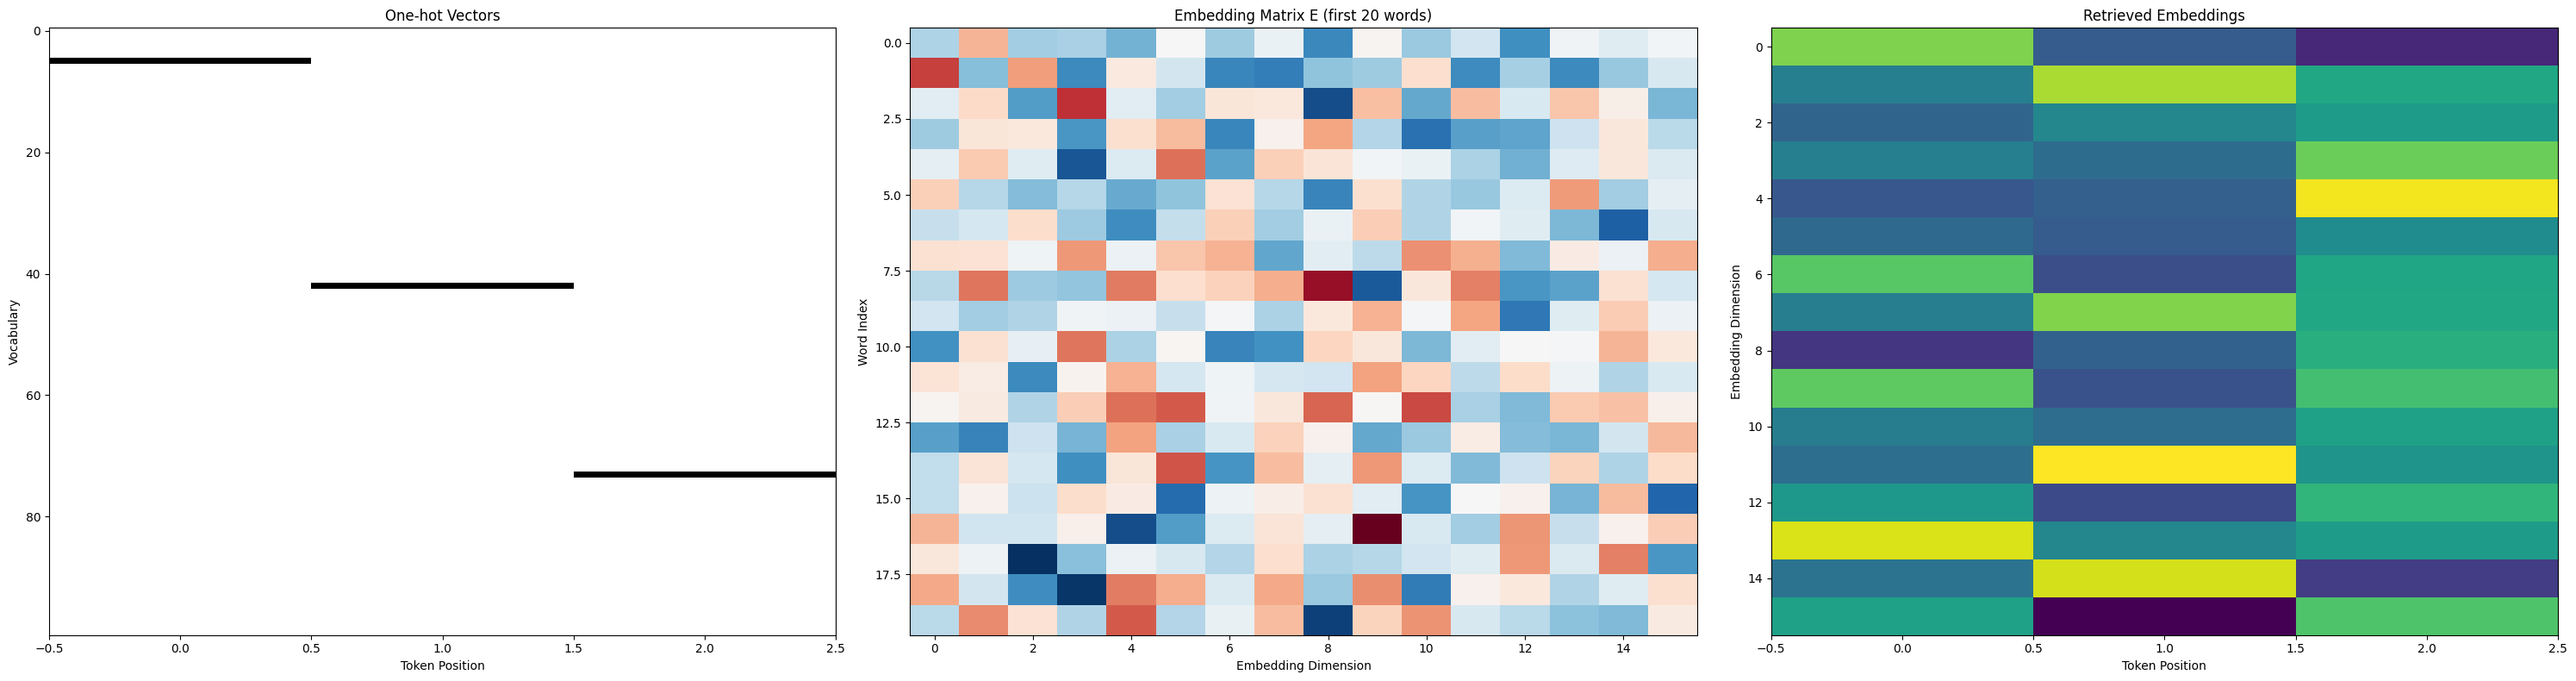

In [46]:
def demonstrate_embedding_lookup():
  """Show equivalence of one-hot multiplication and embedding lookup"""
  vocab_size, d_model = 100, 16  # Small vocab for visualization

  # Create embedding matrix
  embed_layer = TokenEmbedding(vocab_size, d_model)

  # Method 1: Index lookup
  token_ids = torch.tensor([5, 42, 73])  # "Thanks for all" - example token indices
  embeddings_lookup = embed_layer(token_ids)  # Direct index → vector lookup
  print(f"Lookup method shape: {embeddings_lookup.shape}")  # [3, 16]
  print(f"embeddings_lookup (transposed):\n {embeddings_lookup.detach().numpy().T}\n")

  # Method 2: One-hot multiplication
  one_hot = F.one_hot(token_ids, num_classes=vocab_size).float()  # [3, 100] sparse matrix
  print(f"One-hot shape: {one_hot.shape}")  # [3 tokens, 100 vocab_size]
  print(f"One-hot shape:\n {one_hot.detach()}\n")

  # Get embedding matrix
  E = embed_layer.embedding.weight  # [vocab_size, d_model] - the learned parameters
  embeddings_matmul = one_hot @ E * math.sqrt(d_model)  # Matrix mult: [3,100] @ [100,16] = [3,16]
  print(f"Matrix multiplication shape: {embeddings_matmul.shape}")
  print(f"Matrix multiplication (transposed):\n  {embeddings_matmul.detach().numpy().T}\n ")

  # Verify they're the same
  assert torch.allclose(embeddings_lookup, embeddings_matmul)  # Both methods are mathematically equivalent
  print("Methods produce identical results!")

  # Visualize
  fig, axes = plt.subplots(1, 3, figsize=(30, 8))

  # One-hot vectors
  axes[0].imshow(one_hot.T, aspect='auto', cmap='Greys')  # Transpose for better visualization
  axes[0].set_title('One-hot Vectors')
  axes[0].set_xlabel('Token Position')
  axes[0].set_ylabel('Vocabulary')

  # Embedding matrix
  axes[1].imshow(E[:20].detach().numpy(), aspect='auto', cmap='RdBu_r')  # Show first 20 words only
  axes[1].set_title('Embedding Matrix E (first 20 words)')
  axes[1].set_xlabel('Embedding Dimension')
  axes[1].set_ylabel('Word Index')

  # Result embeddings
  axes[2].imshow(embeddings_lookup.detach().numpy().T, aspect='auto', cmap='viridis')  # Final embeddings
  axes[2].set_title('Retrieved Embeddings')
  axes[2].set_xlabel('Token Position')
  axes[2].set_ylabel('Embedding Dimension')

  plt.tight_layout()
  plt.show()

demonstrate_embedding_lookup()

##Input Encoding: Positional Encodings

##Sinusoidal positional encodings

In [47]:
class PositionalEncoding(nn.Module):
  """Positional coding using sinusoidal functions """

  def __init__(self, d_model, max_len=5000, base=10000):
    super().__init__()

    # Create sinsoidal position encoding
    pe = torch.zeros(max_len, d_model) # [max_len, d_model] - pre-compute for all positions
    position = torch.arange(0,max_len).unsqueeze(1).float() # [max_len, 1] - position indices

    # Create div_term for the sinusoidal pattern
    div_term = torch.exp(torch.arange(0, d_model, 2).float() *   # Frequency term for each dimension
                         -(math.log(base)/d_model)   )           # Higher dims -> lower frequency


    print("\ndiv_term:", div_term, "\n")

    # Apply sin to even indices
    pe[:, 0::2] = torch.sin(position * div_term) # sin(pos/10000^(2i/d_model))
    print(f"\nDiv_term (frequencies): {div_term[:4].numpy()}")
    print(f"Example - Position 10:")
    for i in range(3):
      print(f"  dim_{2*i} = sin(10 × {div_term[i]:.4f}) = {pe[10, 2*i]:.4f}")


    # Apply cos to odd indices
    pe[:, 1::2] = torch.cos(position * div_term) # cos(pos/10000^(2i/d_model))
    for i in range(3):
      print(f"  dim_{2*i+1} = cos(10 × {div_term[i]:.4f}) = {pe[10, 2*i+1]:.4f}")

    # Register as buffer (not a parameter)
    self.register_buffer('pe', pe.unsqueeze(0)) # [1, max_len, d_model] - saved but not trained
    print(f"\nPE shape: {pe.unsqueeze(0).shape} [batch=1, max_len={max_len}, d_model={d_model}]")


  def forward(self, x):
    """ Add Positional encoding to input embeddings"""

    seq_len = x.size(1)
    return(x + self.pe[:, :seq_len]) # Add positional embeddings




##Absolute positional embeddings

In [48]:
class LearnedPositionalEmbedding(nn.Module):
  """Learned positional embeddings (Absolute Position)"""

  def __init__(self, max_len, d_model):
    super().__init__()
    self.pos_embedding = nn.Embedding(max_len, d_model)  # Learnable lookup table for positions


  def forward(self, x):
    seq_len = x.size(1)
    positions = torch.arange(seq_len, device = x.device)  # [0, 1, 2, ..., seq_len-1]

    return( x + self.pos_embedding(positions))  # Add learned position vectors


### Compare positional encoding methods



div_term: tensor([1.0000e+00, 8.6596e-01, 7.4989e-01, 6.4938e-01, 5.6234e-01, 4.8697e-01,
        4.2170e-01, 3.6517e-01, 3.1623e-01, 2.7384e-01, 2.3714e-01, 2.0535e-01,
        1.7783e-01, 1.5399e-01, 1.3335e-01, 1.1548e-01, 1.0000e-01, 8.6596e-02,
        7.4989e-02, 6.4938e-02, 5.6234e-02, 4.8697e-02, 4.2170e-02, 3.6517e-02,
        3.1623e-02, 2.7384e-02, 2.3714e-02, 2.0535e-02, 1.7783e-02, 1.5399e-02,
        1.3335e-02, 1.1548e-02, 1.0000e-02, 8.6596e-03, 7.4989e-03, 6.4938e-03,
        5.6234e-03, 4.8697e-03, 4.2170e-03, 3.6517e-03, 3.1623e-03, 2.7384e-03,
        2.3714e-03, 2.0535e-03, 1.7783e-03, 1.5399e-03, 1.3335e-03, 1.1548e-03,
        1.0000e-03, 8.6596e-04, 7.4989e-04, 6.4938e-04, 5.6234e-04, 4.8697e-04,
        4.2170e-04, 3.6517e-04, 3.1623e-04, 2.7384e-04, 2.3714e-04, 2.0535e-04,
        1.7783e-04, 1.5399e-04, 1.3335e-04, 1.1548e-04]) 


Div_term (frequencies): [1.         0.8659643  0.7498942  0.64938164]
Example - Position 10:
  dim_0 = sin(10 × 1.0000) = -0.5440

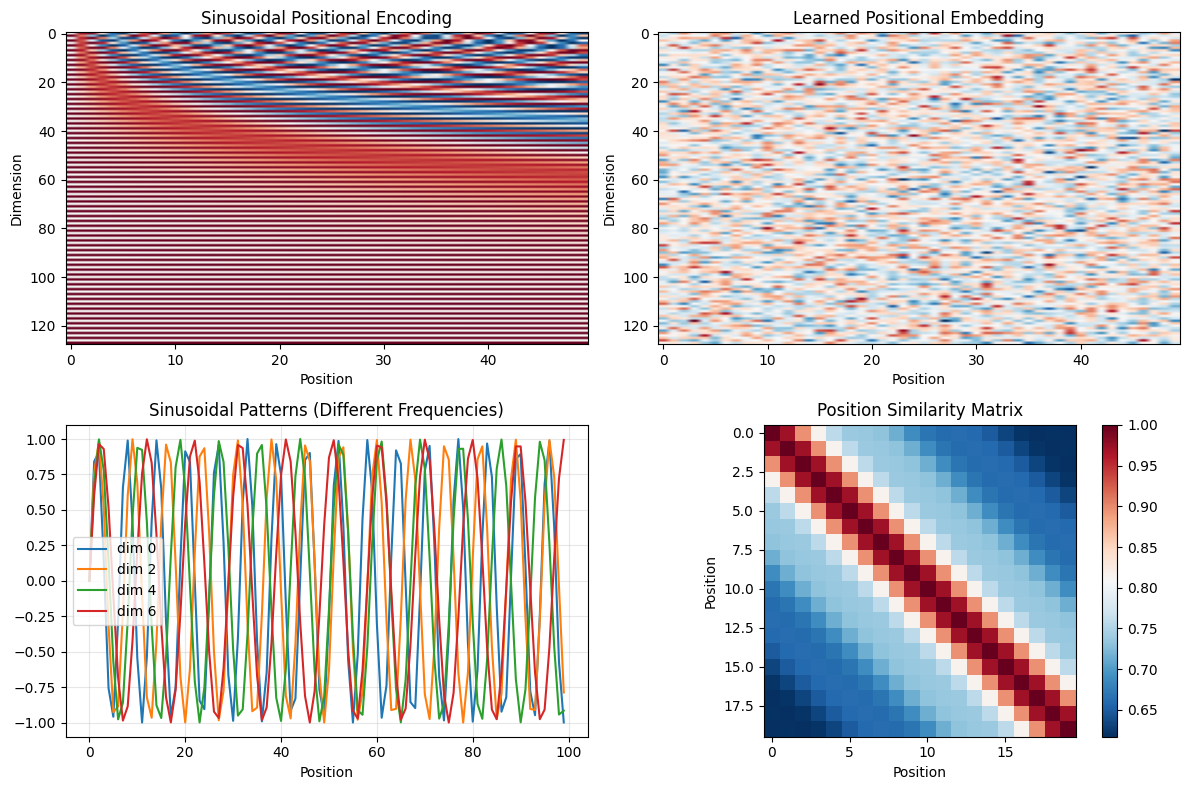


=== KEY PROPERTIES ===
Sinusoidal encoding properties:
- Deterministic (no parameters to learn)
- Can extrapolate to longer sequences
- Different frequencies for different dimensions

Learned encoding properties:
- Flexible, can learn task-specific patterns
- Requires training data for each position
- Limited to maximum sequence length seen during training


In [51]:
def compare_positional_encodings():
  """Visualize different positional encoding strategies"""

  d_model = 128  # Embedding dimension
  max_len = 100  # Maximum sequence length

  # Sinusoidal encoding
  sine_pe = PositionalEncoding(d_model, max_len)  # Fixed mathematical formula

  # Learned encoding
  learned_pe = LearnedPositionalEmbedding(max_len, d_model)  # Trainable parameters

  # Get encodings
  dummy_input = torch.zeros(1, max_len, d_model)  # Dummy input for shape
  sine_encoding = sine_pe.pe[0, :max_len, :].numpy()  # Extract sinusoidal patterns
  learned_encoding = learned_pe.pos_embedding.weight.detach().numpy()  # Extract learned embeddings

  # Print shapes and sample values
  print(f"=== POSITIONAL ENCODING SHAPES ===")
  print(f"Sinusoidal encoding shape: {sine_encoding.shape} [positions, d_model]")
  print(f"Learned encoding shape: {learned_encoding.shape} [positions, d_model]")

  print(f"\n=== SAMPLE ENCODINGS (first 3 positions, first 8 dims) ===")
  print(f"Sinusoidal encoding (positions 0-2):")
  print(f"{sine_encoding[:3, :8]}")

  print(f"\nLearned encoding (positions 0-2):")
  print(f"{learned_encoding[:3, :8]}")

  print(f"\n=== ENCODING PATTERNS ===")
  print(f"Sine encoding at pos=0: min={sine_encoding[0].min():.3f}, max={sine_encoding[0].max():.3f}")
  print(f"Sine encoding at pos=50: min={sine_encoding[50].min():.3f}, max={sine_encoding[50].max():.3f}")
  print(f"Notice: Sinusoidal values stay bounded in [-1, 1]")

  print(f"\n=== FREQUENCY ANALYSIS ===")
  print(f"Dimension 0 (high freq): changes from {sine_encoding[0, 0]:.3f} to {sine_encoding[1, 0]:.3f} (Δ={abs(sine_encoding[1, 0] - sine_encoding[0, 0]):.3f})")
  print(f"Dimension 126 (low freq): changes from {sine_encoding[0, 126]:.3f} to {sine_encoding[1, 126]:.3f} (Δ={abs(sine_encoding[1, 126] - sine_encoding[0, 126]):.3f})")
  print(f"Lower dimensions change faster between positions!")

  # Visualize
  fig, axes = plt.subplots(2, 2, figsize=(12, 8))

  # Sinusoidal pattern
  axes[0, 0].imshow(sine_encoding[:50].T, aspect='auto', cmap='RdBu_r')  # Show wave patterns
  axes[0, 0].set_title('Sinusoidal Positional Encoding')
  axes[0, 0].set_xlabel('Position')
  axes[0, 0].set_ylabel('Dimension')

  # Learned pattern
  axes[0, 1].imshow(learned_encoding[:50].T, aspect='auto', cmap='RdBu_r')  # Random init patterns
  axes[0, 1].set_title('Learned Positional Embedding')
  axes[0, 1].set_xlabel('Position')
  axes[0, 1].set_ylabel('Dimension')

  # Sinusoidal patterns for specific dimensions
  positions = np.arange(100)
  for i in range(0, 8, 2):  # Show different frequency waves
    axes[1, 0].plot(positions, sine_encoding[:, i], label=f'dim {i}')
  axes[1, 0].set_title('Sinusoidal Patterns (Different Frequencies)')
  axes[1, 0].set_xlabel('Position')
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # Similarity matrix for positions
  from sklearn.metrics.pairwise import cosine_similarity
  sim_matrix = cosine_similarity(sine_encoding[:20])  # How similar are different positions?

  print(f"\n=== POSITION SIMILARITY ===")
  print(f"Similarity matrix shape: {sim_matrix.shape}")
  print(f"Similarity between pos 0 and pos 1: {sim_matrix[0, 1]:.3f}")
  print(f"Similarity between pos 0 and pos 10: {sim_matrix[0, 10]:.3f}")
  print(f"Similarity between pos 0 and pos 19: {sim_matrix[0, 19]:.3f}")
  print(f"Notice: Nearby positions are more similar!")

  axes[1, 1].imshow(sim_matrix, cmap='RdBu_r')
  axes[1, 1].set_title('Position Similarity Matrix')
  axes[1, 1].set_xlabel('Position')
  axes[1, 1].set_ylabel('Position')
  axes[1, 1].colorbar = plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1])

  plt.tight_layout()
  plt.show()

  print("\nKEY PROPERTIES")
  print("Sinusoidal encoding properties:")
  print("- Deterministic (no parameters to learn)")  # Always same pattern
  print("- Can extrapolate to longer sequences")  # Works for any length
  print("- Different frequencies for different dimensions")  # Low->high freq across dims
  print("\nLearned encoding properties:")
  print("- Flexible, can learn task-specific patterns")  # Adapts to data
  print("- Requires training data for each position")  # Must see positions during training
  print("- Limited to maximum sequence length seen during training")  # Can't extend

compare_positional_encodings()